In [ ]:
!pip install transformers

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange, tnrange,tqdm_notebook
import random
import os
import io
import itertools

In [ ]:
SEED = 19
DeviceTypeCUDA = "cuda"
DeviceTypeCPU = "cpu"
random.seed(SEED)
np.random.seed(SEED)
device = torch.device(DeviceTypeCUDA if torch.cuda.is_available() else DeviceTypeCPU)
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.manual_seed(SEED)
if device == torch.device(DeviceTypeCUDA):
    torch.cuda.manual_seed_all(SEED)

In [ ]:
df_train = pd.read_csv("/content/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("/content/test.txt", delimiter=';', header=None, names=['sentence','label'])
df_val  = pd.read_csv("/content/val.txt", delimiter=';', header=None, names=['sentence','label'])
df = pd.concat([df_train,df_test,df_val])
df['label'].unique()
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])
label_mapping = df[['label', 'label_enc']].drop_duplicates(keep='first')
df.rename(columns={'label': 'label_desc', 'label_enc': 'label'}, inplace=True)
## lexicographical order
print(label_mapping)

      label  label_enc
0   sadness          4
2     anger          0
3      love          3
6  surprise          5
7      fear          1
8       joy          2


In [ ]:
sentences = df.sentence.values
print(df.label.value_counts())

## Tokenize and Encode Sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
input_ids = []
for sentence in sentences:
    encoded_sent = tokenizer.encode(sentence,add_special_tokens=True,max_length=128,padding='max_length')
    input_ids.append(encoded_sent)
labels = df.label.values
'''
Output Example
Original Sentence:
For example: "I feel so sad today."
Tokenized and Encoded Result:
The tokenizer might produce: ["[CLS]", "i", "feel", "so", "sad", "today", ".", "[SEP]", 0, 0, ...].
Each token is mapped to a unique ID: [101, 1045, 2514, 2061, 4165, 2651, 1012, 102, 0, 0, ...].
[101]: [CLS] token, indicating the start of the sequence.
[102]: [SEP] token, marking the end of the sequence.
0: Padding added to make the sequence length equal to MAX_LEN.
'''

label
2    6761
4    5797
0    2709
1    2373
3    1641
5     719
Name: count, dtype: int64


'\nOutput Example\nOriginal Sentence:\nFor example: "I feel so sad today."\nTokenized and Encoded Result:\nThe tokenizer might produce: ["[CLS]", "i", "feel", "so", "sad", "today", ".", "[SEP]", 0, 0, ...].\nEach token is mapped to a unique ID: [101, 1045, 2514, 2061, 4165, 2651, 1012, 102, 0, 0, ...].\n[101]: [CLS] token, indicating the start of the sequence.\n[102]: [SEP] token, marking the end of the sequence.\n0: Padding added to make the sequence length equal to MAX_LEN.\n'

In [ ]:
### Functionality: Initializes an empty list to store the attention mask for each sentence.
attention_masks = []
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
'''
Example:
Suppose an input sequence is [101, 1045, 2514, 2061, 4165, 2651, 1012, 102, 0, 0, ...].
The corresponding attention mask would be [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...].
'''

'\nExample:\nSuppose an input sequence is [101, 1045, 2514, 2061, 4165, 2651, 1012, 102, 0, 0, ...].\nThe corresponding attention mask would be [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...].\n'

Dataset Preparation

In [ ]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

## splits the dataset into training and validation sets for both inputs (tokenized text) and corresponding labels, as well as their attention masks.

def Converttensors(inputs, labels, masks):
    inputs_tensor = torch.tensor(inputs)
    labels_tensor = torch.tensor(labels)
    masks_tensor = torch.tensor(masks)
    return inputs_tensor, labels_tensor, masks_tensor

def Getdataloader(inputs, masks, labels):
    data = TensorDataset(inputs, masks, labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=32)
    return data, sampler ,dataloader

train_inputs, train_labels, train_masks = Converttensors(train_inputs, train_labels, train_masks)
validation_inputs, validation_labels, validation_masks = Converttensors(validation_inputs, validation_labels, validation_masks)

train_data, train_sampler, train_dataloader = Getdataloader(train_inputs, train_masks, train_labels)
validation_data, validation_sampler, validation_dataloader = Getdataloader(validation_inputs, validation_masks, validation_labels)


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_loss_set = []
learning_rate = []
model.zero_grad()
epochs = 3


def LogEpochStatistics(optimizer, avg_train_loss, train_loss_set, learning_rate):
    print(f"\n\tAverage Training Loss: {avg_train_loss}")
    train_loss_set.append(avg_train_loss)
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"\n\tCurrent Learning Rate: {current_lr}")
        learning_rate.append(current_lr)


for _ in trange(1, epochs + 1, desc='Epoch'):
  print("<" + "*"*30 + F" Epoch {_} " + "*"*30 + ">")
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    model.train()
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    batch_loss += loss.item()

  LogEpochStatistics(optimizer, batch_loss / len(train_dataloader), train_loss_set, learning_rate)

  model.eval()

  eval_accuracy = 0
  eval_mcc_accuracy = 0
  nb_eval_steps = 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  avg_eval_accuracy = eval_accuracy / nb_eval_steps
  avg_eval_mcc_accuracy = eval_mcc_accuracy / nb_eval_steps


  validation_metrics = (f"\n\tValidation Accuracy: {avg_eval_accuracy:.4f}\n" f"\tValidation MCC Accuracy: {avg_eval_mcc_accuracy:.4f}")
  print(validation_metrics)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<****************************** Epoch 1 ******************************>

	Average Training Loss: 0.5536503113118094

	Current Learning Rate: 1.3333333333333333e-05


Epoch:  33%|███▎      | 1/3 [05:54<11:49, 354.56s/it]


	Validation Accuracy: 0.9182
	Validation MCC Accuracy: 0.8945
<****************************** Epoch 2 ******************************>

	Average Training Loss: 0.14404612077734238

	Current Learning Rate: 6.666666666666667e-06


Epoch:  67%|██████▋   | 2/3 [11:49<05:54, 354.57s/it]


	Validation Accuracy: 0.9271
	Validation MCC Accuracy: 0.9043
<****************************** Epoch 3 ******************************>

	Average Training Loss: 0.09530076226236077

	Current Learning Rate: 0.0


Epoch: 100%|██████████| 3/3 [17:45<00:00, 355.13s/it]


	Validation Accuracy: 0.9261
	Validation MCC Accuracy: 0.9039


In [ ]:
df[['label','label_desc']].drop_duplicates(keep='first')
label2int = {
  "sadness": 4,
  "joy": 2,
  "anger": 0,
    "love":3,
  "fear": 1,
  "surprise": 5
}
df_metrics['Predicted_class'].unique()
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

     sadness   0.750000  1.000000  0.857143         3
         joy   1.000000  1.000000  1.000000         1
       anger   0.666667  0.666667  0.666667         3
        love   1.000000  0.500000  0.666667         2
        fear   1.000000  0.857143  0.923077         7
    surprise   0.000000  0.000000  0.000000         0

    accuracy                       0.812500        16
   macro avg   0.736111  0.670635  0.685592        16
weighted avg   0.890625  0.812500  0.835394        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


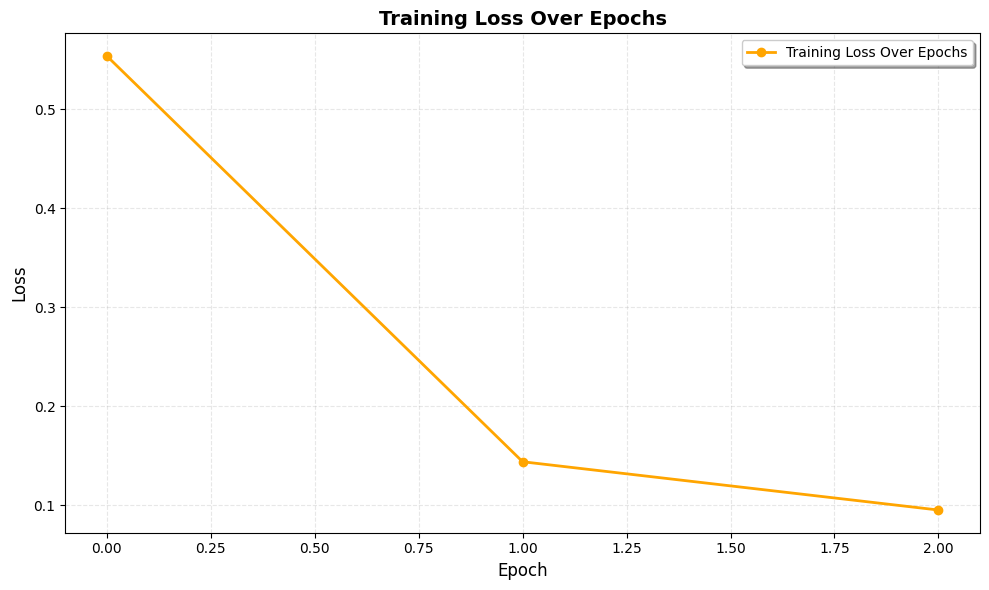

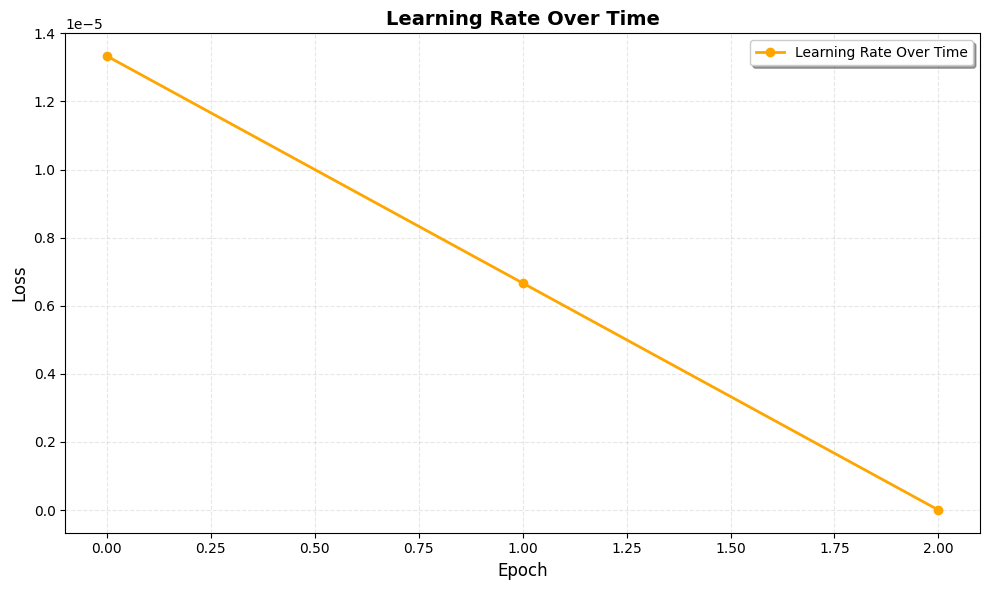

In [ ]:
def PltTrainResult(data, label, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label=title, color="orange", linestyle="-", marker="o", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend(loc="upper right", fontsize=10, frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()

PltTrainResult(train_loss_set, "Training loss", "Epoch", "Loss", "Training Loss Over Epochs")
PltTrainResult(learning_rate, "Learning rate", "Step", "Learning Rate", "Learning Rate Over Time")

In [ ]:
def SaveModel(model, tokenizer, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

def LoadModel(output_dir, device):
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model = BertForSequenceClassification.from_pretrained(output_dir)
    model.to(device)
    model.eval()
    return model, tokenizer


output_dir = '/working/bert_emotion_model/'
device = torch.device(DeviceTypeCUDA if torch.cuda.is_available() else DeviceTypeCPU)


SaveModel(model, tokenizer, output_dir)


model, tokenizer = LoadModel(output_dir, device)


In [ ]:
def predict_emotion(text, model, tokenizer, max_len=128):
    inputs = tokenizer.encode_plus(text,add_special_tokens=True,max_length=max_len,padding='max_length',return_attention_mask=True,truncation=True,return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class, probabilities[0].cpu().numpy()

In [ ]:
emotion_labels = ['anger', 'fear', 'joy', 'love','sadness', 'surprise']

In [ ]:
text = "I'm feeling so happy today!"
predicted_class, probs = predict_emotion(text, model, tokenizer)
print(f'Predicted Emotion: {emotion_labels[predicted_class]}')
print(f'Probabilities: {probs}')

Predicted Emotion: joy
Probabilities: [2.3842156e-04 2.5150127e-04 9.9801981e-01 7.1476458e-04 4.2176983e-04
 3.5368939e-04]
